# Gradient Boosting Machines (GBM) with XGBoost and LightBGM

In [568]:
import opendatasets as od
import os
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

In [579]:
!pip install xgboost lightgbm graphviz scikit-learn --upgrade

  Using cached xgboost-2.1.3-py3-none-win_amd64.whl.metadata (2.1 kB)
  Using cached graphviz-0.20.3-py3-none-any.whl.metadata (12 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.1/124.9 MB 2.0 MB/s eta 0:01:04
   ---------------------------------------- 0.8/124.9 MB 7.3 MB/s eta 0:00:18
    --------------------------------------- 1.9/124.9 MB 11.9 MB/s eta 0:00:11
   - -------------------------------------- 3.2/124.9 MB 15.5 MB/s eta 0:00:08
   - -------------------------------------- 4.8/124.9 MB 19.2 MB/s eta 0:00:07
   -- ------------------------------------- 6.6/124.9 MB 22.1 MB/s eta 0:00:06
   -- ------------------------------------- 8.6/124.9 MB 24.9 MB/s eta 0:00:05
   --- ------------------------------------ 10.6/124.9 MB 34.4 MB/s eta 0:00:04
   ---- ---------------

  You can safely remove it manually.


In [572]:
od.download('https://www.kaggle.com/competitions/rossmann-store-sales')

Skipping, found downloaded files in ".\rossmann-store-sales" (use force=True to force download)


## Description
Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

In their first Kaggle competition, Rossmann is challenging you to predict 6 weeks of daily sales for 1,115 stores located across Germany. Reliable sales forecasts enable store managers to create effective staff schedules that increase productivity and motivation. By helping Rossmann create a robust prediction model, you will help store managers stay focused on what’s most important to them: their customers and their teams! 

## Dataset Description
You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.### 

Files
train.csv - historical data including Sales
test.csv - historical data excluding Sales
sample_submission.csv - a sample submission file in the correct format
store.csv - supplemental information about the

 ### stores
Dat
 fields
Most of the fields are self-explanatory. The following are descriptions for those tha

- **Id**: An Id representing a (Store, Date) duple within the test set.
- **Store**: A unique Id for each store.
- **Sales**: The turnover for any given day (this is the target variable to predict).
- **Customers**: The number of customers on a given day.
- **Open**: Indicator for whether the store was open:
  - `0`: Closed
  - `1`: Open
- **StateHoliday**: Indicates a state holiday:
  - `a`: Public holiday
  - `b`: Easter holiday
  - `c`: Christmas
  - `0`: None
  - Note: Normally all stores, with few exceptions, are closed on state holidays. Schools are closed on public holidays and weekends.
- **SchoolHoliday**: Indicates if the (Store, Date) was affected by the closure of public schools.
- **StoreType**: Differentiates between 4 different store models:
  - `a`, `b`, `c`, `d`
- **Assortment**: Describes the assortment level:
  - `a`: Basic
  - `b`: Extra
  - `c`: Extended
- **CompetitionDistance**: Distance in meters to the nearest competitor store.
- **CompetitionOpenSince[Month/Year]**: Approximate year and month when the nearest competitor store was opened.
- **Promo**: Indicates whether a store is running a promotion on that day.
- **Promo2**: A continuing and consecutive promotion for some stores:
  - `0`: Store is not participating
  - `1`: Store is participating
- **Promo2Since[Year/Week]**: The year and calendar week when the store started participating in Promo2.
- **PromoInterval**: Describes the consecutive intervals Promo2 starts, naming the months the promotion starts anew.
  - Example: `"Feb,May,Aug,Nov"` means the promotion starts in February, May, August, and November of any given year for that store.
a
  - `c`: Extende
given year for that store

In [573]:
os.listdir('rossmann-store-sales')

['sample_submission.csv', 'store.csv', 'test.csv', 'train.csv']

In [595]:
ross_df = pd.read_csv('./rossmann-store-sales/train.csv')
store_df = pd.read_csv('./rossmann-store-sales/store.csv')
test_df = pd.read_csv('rossmann-store-sales/test.csv')
submission_df = pd.read_csv('./rossmann-store-sales/sample_submission.csv')

C:\Users\VIVEK\AppData\Local\Temp\ipykernel_25468\2402061528.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  ross_df = pd.read_csv('./rossmann-store-sales/train.csv')


In [597]:
ross_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


In [599]:
store_df

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [601]:
test_df

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0
...,...,...,...,...,...,...,...,...
41083,41084,1111,6,2015-08-01,1.0,0,0,0
41084,41085,1112,6,2015-08-01,1.0,0,0,0
41085,41086,1113,6,2015-08-01,1.0,0,0,0
41086,41087,1114,6,2015-08-01,1.0,0,0,0


In [603]:
submission_df

,Id,Sales
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
41083,41084,0
41084,41085,0
41085,41086,0
41086,41087,0


In [611]:
merged_df = ross_df.merge(store_df, how='left', on='Store')
merged_test_df = test_df.merge(store_df, how='left', on='Store')

In [613]:
merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [615]:
merged_test_df

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,1,4,2015-09-17,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,3,4,2015-09-17,1.0,1,0,0,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
2,3,7,4,2015-09-17,1.0,1,0,0,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
3,4,8,4,2015-09-17,1.0,1,0,0,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
4,5,9,4,2015-09-17,1.0,1,0,0,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41083,41084,1111,6,2015-08-01,1.0,0,0,0,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
41084,41085,1112,6,2015-08-01,1.0,0,0,0,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
41085,41086,1113,6,2015-08-01,1.0,0,0,0,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
41086,41087,1114,6,2015-08-01,1.0,0,0,0,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


## Preprocessing & Feature Engineering

In [618]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

In [620]:
def split_date(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['Day'] = df.Date.dt.day
    df['Month'] = df.Date.dt.month
    df['Year'] = df.Date.dt.year
    df['WeekOfYear'] = df.Date.dt.isocalendar().week

In [622]:
split_date(merged_df)
split_date(merged_test_df)

In [624]:
merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Day,Month,Year,WeekOfYear
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,31,7,2015,31
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",31,7,2015,31
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",31,7,2015,31
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,31,7,2015,31
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,31,7,2015,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",1,1,2013,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN,1,1,2013,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN,1,1,2013,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN,1,1,2013,1


### Store Open/Closed

Since the sales are 0 whenever the store is closed.

In [628]:
merged_df[merged_df.Open == 0].Sales.value_counts()

Sales
0    172817
Name: count, dtype: int64

We can just hardcode this in our predictions and not model this relationship. We'll just remove these rows in the test set.

In [638]:
merged_df = merged_df[merged_df.Open == 1].copy()

### Competition

We can use `CompetitionOpenSince[Month/Year]` columns from store_df to compute the number of months for which a competitor has been open near the store.

In [643]:
merged_df.sample(10)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Day,Month,Year,WeekOfYear
647796,767,4,2013-11-28,7444,743,1,0,0,0,a,c,13080.0,NaN,NaN,0,NaN,NaN,NaN,28,11,2013,48
229310,736,3,2015-01-07,7091,603,1,1,0,0,c,c,1650.0,NaN,NaN,1,14.0,2011.0,"Jan,Apr,Jul,Oct",7,1,2015,2
386848,1036,4,2014-07-24,5394,496,1,0,0,1,d,c,9560.0,NaN,NaN,1,36.0,2013.0,"Jan,Apr,Jul,Oct",24,7,2014,30
791444,580,1,2013-07-22,10043,1695,1,0,0,1,a,c,170.0,2.0,2009.0,0,NaN,NaN,NaN,22,7,2013,30
306833,391,5,2014-10-17,4630,638,1,0,0,1,a,a,460.0,11.0,2014.0,1,31.0,2013.0,"Feb,May,Aug,Nov",17,10,2014,42
356436,449,1,2014-08-25,8562,1290,1,0,0,1,a,c,120.0,12.0,2014.0,1,37.0,2009.0,"Jan,Apr,Jul,Oct",25,8,2014,35
23410,1111,6,2015-07-11,2641,231,1,0,0,0,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",11,7,2015,28
398153,21,5,2014-07-11,4351,483,1,0,0,0,c,c,550.0,10.0,1999.0,1,45.0,2009.0,"Jan,Apr,Jul,Oct",11,7,2014,28
375768,87,1,2014-08-04,8362,1016,1,1,0,1,a,a,560.0,12.0,2010.0,0,NaN,NaN,NaN,4,8,2014,32
873062,803,5,2013-05-10,7534,641,1,0,0,0,d,a,1760.0,NaN,NaN,1,10.0,2014.0,"Mar,Jun,Sept,Dec",10,5,2013,19


In [651]:
def comp_months(df):
    df['CompetitionOpen'] = 12 * (df.Year - df.CompetitionOpenSinceYear) + (df.Month - df.CompetitionOpenSinceMonth) # Will create a column that will give us the total months for which the store has been opened
    df['CompetitionOpen'] = df['CompetitionOpen'].map(lambda x: 0 if x < 0 else x).fillna(0) # If there is negative value because there are no competing stores yet, we'll just put 0 there

In [653]:
comp_months(merged_df)
comp_months(merged_test_df)

New columns we have created

In [658]:
merged_df[['Date', 'CompetitionDistance', 'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth', 'CompetitionOpen']]

,Date,CompetitionDistance,CompetitionOpenSinceYear,CompetitionOpenSinceMonth,CompetitionOpen
0,2015-07-31,1270.0,2008.0,9.0,82.0
1,2015-07-31,570.0,2007.0,11.0,92.0
2,2015-07-31,14130.0,2006.0,12.0,103.0
3,2015-07-31,620.0,2009.0,9.0,70.0
4,2015-07-31,29910.0,2015.0,4.0,3.0
...,...,...,...,...,...
1016776,2013-01-01,150.0,2006.0,9.0,76.0
1016827,2013-01-01,860.0,1999.0,10.0,159.0
1016863,2013-01-01,840.0,NaN,NaN,0.0
1017042,2013-01-01,1430.0,NaN,NaN,0.0


In [662]:
merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Day,Month,Year,WeekOfYear,CompetitionOpen
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,31,7,2015,31,82.0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",31,7,2015,31,92.0
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",31,7,2015,31,103.0
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,31,7,2015,31,70.0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,31,7,2015,31,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,3375,566,1,0,a,1,b,a,150.0,9.0,2006.0,0,NaN,NaN,NaN,1,1,2013,1,76.0
1016827,733,2,2013-01-01,10765,2377,1,0,a,1,b,b,860.0,10.0,1999.0,0,NaN,NaN,NaN,1,1,2013,1,159.0
1016863,769,2,2013-01-01,5035,1248,1,0,a,1,b,b,840.0,NaN,NaN,1,48.0,2012.0,"Jan,Apr,Jul,Oct",1,1,2013,1,0.0
1017042,948,2,2013-01-01,4491,1039,1,0,a,1,b,b,1430.0,NaN,NaN,0,NaN,NaN,NaN,1,1,2013,1,0.0


In [753]:
def check_promo_month(row):
    month2str = {1: 'Jan', 2: 'Feb',3: 'Mar',4: 'Apr', 5: 'May', 6: 'Jun', 
                 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
    try:
        months = (row['PromoInterval'] or '').split(',')
        if row['Promo2Open'] and month2str[row['Month']] in months:
            return 1
        else:
            return 0
    except Exception:
        return 0

def promo_cols(df):
    # Months since Promo2 was open
    df['Promo2Open'] = 12 * (df.Year - df.Promo2SinceYear) + (df.WeekOfYear - df.Promo2SinceWeek) * 52
    df['Promo2Open'] = df['Promo2Open'].map(lambda x: 0 if x < 0 else x).fillna(0) * df['Promo2']
    # Whether a new round of promotions was started in the current month
    df['IsPromo2Month'] = df.apply(check_promo_month, axis=1) * df['Promo2']

In [755]:
promo_cols(merged_df)
promo_cols(merged_test_df)

In [756]:
merged_df[['Date', 'Promo2', 'Promo2SinceYear', 'Promo2SinceWeek', 'PromoInterval', 'Promo2Open', 'IsPromo2Month']]

,Date,Promo2,Promo2SinceYear,Promo2SinceWeek,PromoInterval,Promo2Open,IsPromo2Month
0,2015-07-31,0,NaN,NaN,NaN,0.0,0
1,2015-07-31,1,2010.0,13.0,"Jan,Apr,Jul,Oct",996.0,1
2,2015-07-31,1,2011.0,14.0,"Jan,Apr,Jul,Oct",932.0,1
3,2015-07-31,0,NaN,NaN,NaN,0.0,0
4,2015-07-31,0,NaN,NaN,NaN,0.0,0
...,...,...,...,...,...,...,...
1016776,2013-01-01,0,NaN,NaN,NaN,0.0,0
1016827,2013-01-01,0,NaN,NaN,NaN,0.0,0
1016863,2013-01-01,1,2012.0,48.0,"Jan,Apr,Jul,Oct",0.0,0
1017042,2013-01-01,0,NaN,NaN,NaN,0.0,0


## Input and Target Columns

In [764]:
merged_df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Day', 'Month', 'Year',
       'WeekOfYear', 'CompetitionOpen', 'Promo2Open', 'IsPromo2Month'],
      dtype='object')

In [766]:
input_cols = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 
              'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpen', 
              'Day', 'Month', 'Year', 'WeekOfYear', 'Promo2', 
              'Promo2Open', 'IsPromo2Month']
target_col = 'Sales'

In [770]:
inputs = merged_df[input_cols].copy()
targets = merged_df[target_col].copy()

In [775]:
inputs

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpen,Day,Month,Year,WeekOfYear,Promo2,Promo2Open,IsPromo2Month
0,1,5,1,0,1,c,a,1270.0,82.0,31,7,2015,31,0,0.0,0
1,2,5,1,0,1,a,a,570.0,92.0,31,7,2015,31,1,996.0,1
2,3,5,1,0,1,a,a,14130.0,103.0,31,7,2015,31,1,932.0,1
3,4,5,1,0,1,c,c,620.0,70.0,31,7,2015,31,0,0.0,0
4,5,5,1,0,1,a,a,29910.0,3.0,31,7,2015,31,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,0,a,1,b,a,150.0,76.0,1,1,2013,1,0,0.0,0
1016827,733,2,0,a,1,b,b,860.0,159.0,1,1,2013,1,0,0.0,0
1016863,769,2,0,a,1,b,b,840.0,0.0,1,1,2013,1,1,0.0,0
1017042,948,2,0,a,1,b,b,1430.0,0.0,1,1,2013,1,0,0.0,0


In [777]:
targets

0           5263
1           6064
2           8314
3          13995
4           4822
           ...  
1016776     3375
1016827    10765
1016863     5035
1017042     4491
1017190     5961
Name: Sales, Length: 844392, dtype: int64

In [772]:
test_inputs = merged_test_df[input_cols].copy()

Identifying the numeric and categorical cols

In [779]:
test_inputs

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpen,Day,Month,Year,WeekOfYear,Promo2,Promo2Open,IsPromo2Month
0,1,4,1,0,0,c,a,1270.0,84.0,17,9,2015,38,0,0.0,0
1,3,4,1,0,0,a,a,14130.0,105.0,17,9,2015,38,1,1296.0,0
2,7,4,1,0,0,a,c,24000.0,29.0,17,9,2015,38,0,0.0,0
3,8,4,1,0,0,a,a,7520.0,11.0,17,9,2015,38,0,0.0,0
4,9,4,1,0,0,a,c,2030.0,181.0,17,9,2015,38,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41083,1111,6,0,0,0,a,a,1900.0,14.0,1,8,2015,31,1,24.0,0
41084,1112,6,0,0,0,c,c,1880.0,112.0,1,8,2015,31,0,0.0,0
41085,1113,6,0,0,0,a,c,9260.0,0.0,1,8,2015,31,0,0.0,0
41086,1114,6,0,0,0,a,c,870.0,0.0,1,8,2015,31,0,0.0,0


In [788]:
numeric_cols = ['Store', 'Promo', 'SchoolHoliday', 'CompetitionDistance', 'CompetitionOpen', 'Promo2', 'Promo2Open', 
                    'IsPromo2Month', 'Day', 'Month', 'Year', 'WeekOfYear']

categorical_cols = ['DayOfWeek', 'StateHoliday', 'StoreType', 'Assortment']

## Imputing missing Numerical Data

In [791]:
inputs[numeric_cols].isna().sum()

Store                     0
Promo                     0
SchoolHoliday             0
CompetitionDistance    2186
CompetitionOpen           0
Promo2                    0
Promo2Open                0
IsPromo2Month             0
Day                       0
Month                     0
Year                      0
WeekOfYear                0
dtype: int64

In [793]:
test_inputs[numeric_cols].isna().sum()

Store                   0
Promo                   0
SchoolHoliday           0
CompetitionDistance    96
CompetitionOpen         0
Promo2                  0
Promo2Open              0
IsPromo2Month           0
Day                     0
Month                   0
Year                    0
WeekOfYear              0
dtype: int64

Competition distance is the only column with missing values, indicating that there is no competition nearby. Therefore we can impute the max distance value to these rows, meaning that the competition is just very far away.

In [796]:
max_distance = inputs.CompetitionDistance.max()
max_distance

75860.0

In [800]:
inputs['CompetitionDistance'].fillna(max_distance * 2, inplace=True)
test_inputs['CompetitionDistance'].fillna(max_distance * 2, inplace=True)

C:\Users\VIVEK\AppData\Local\Temp\ipykernel_25468\1685294416.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  inputs['CompetitionDistance'].fillna(max_distance * 2, inplace=True)
C:\Users\VIVEK\AppData\Local\Temp\ipykernel_25468\1685294416.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves

## Scale Numeric Values

In [803]:
from sklearn.preprocessing import MinMaxScaler

In [805]:
scaler = MinMaxScaler().fit(inputs[numeric_cols])

In [807]:
inputs[numeric_cols] = scaler.transform(inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

## Encoding categorical Columns

In [810]:
from sklearn.preprocessing import OneHotEncoder

In [814]:
inputs[categorical_cols] = inputs[categorical_cols].astype(str).fillna('')
test_inputs[categorical_cols] = test_inputs[categorical_cols].astype(str).fillna('')

In [816]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit(inputs[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))

In [823]:
inputs[encoded_cols] = encoder.transform(inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

Finally, let's extract the numeric data for training

In [826]:
X = inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

We'll use K-fold cross validation for the validation set

## Gradient Boosting

Gradient Boosting is a powerful machine learning technique used for regression and classification tasks. It builds models sequentially, with each new model correcting the errors made by the previous ones. This is achieved by combining weak learners, typically decision trees, into a strong predictive model.

### Key Concepts:

1. **Boosting**: 
   - Boosting is an ensemble method that combines the predictions of several base models (weak learners) to improve performance.
   - Gradient Boosting is a specific type of boosting that uses gradients to minimize errors.

2. **Weak Learners**:
   - Decision trees with a small depth (e.g., stumps) are commonly used as weak learners.
   - They perform slightly better than random guessing but are improved in later steps.

3. **Loss Function**:
   - The loss function measures the difference between predicted and actual values (e.g., Mean Squared Error for regression, Log Loss for classification).
   - Gradient Boosting minimizes this loss function.

4. **Gradient Descent**:
   - It uses gradient descent to optimize the loss function iteratively.
   - Each subsequent model learns from the residuals (errors) of the previous model.

5. **Additive Modeling**:
   - Models are added sequentially, and each model is weighted based on its performance.
   - The final prediction is a weighted sum of all the models.

---

### How Gradient Boosting Works:

1. **Initialize**:
   - Start with a simple model, usually predicting the mean value for regression or uniform probability for classification.

2. **Compute Residuals**:
   - Calculate the residuals (difference between the actual and predicted values).

3. **Fit a Weak Learner**:
   - Train a weak learner (e.g., a small decision tree) to predict the residuals.

4. **Update Model**:
   - Add the predictions of the weak learner to the overall model predictions, scaled by a learning rate.

5. **Iterate**:
   - Repeat steps 2–4 for a fixed number of iterations or until convergence.

6. **Final Prediction**:
   - Combine all the weak learners' predictions into a strong model.

---

### Parameters in Gradient Boosting:

1. **Learning Rate**:
   - Determines the contribution of each tree to the final model.
   - A smaller value often requires more iterations but can improve accuracy.

2. **Number of Estimators**:
   - The number of weak learners (trees) to train.
   - More estimators increase the model complexity.

3. **Max Depth**:
   - Limits the depth of each tree to prevent overfitting.

4. **Subsample**:
   - The fraction of samples used to train each tree, helping to reduce overfitting.

5. **Loss Function**:
   - Specifies the objective (e.g., squared error for regression, log loss for classification).

---

### Popular Implementations:
1. **XGBoost**: Highly efficient and scalable implementation of gradient boosting.
2. **LightGBM**: Optimized for speed and performance, handles large datasets well.
3. **CatBoost**: Handles categorical features natively and reduces overfitting.

Gradient Boosting is widely used in various applications, including ranking systems, fraud detection, and predictive modeling in finance and healthcare.

## Training

In [835]:
from xgboost import XGBRegressor

In [837]:
?XGBRegressor

Init signature:
XGBRegressor(
    *,
    objective: Union[str, xgboost.sklearn._SklObjWProto, Callable[[Any, Any], Tuple[numpy.ndarray, numpy.ndarray]], NoneType] = 'reg:squarederror',
    **kwargs: Any,
) -> None
Docstring:     
Implementation of the scikit-learn API for XGBoost regression.
See :doc:`/python/sklearn_estimator` for more information.

Parameters
----------

    n_estimators : typing.Optional[int]
        Number of gradient boosted trees.  Equivalent to number of boosting
        rounds.

    max_depth :  typing.Optional[int]

        Maximum tree depth for base learners.

    max_leaves : typing.Optional[int]

        Maximum number of leaves; 0 indicates no limit.

    max_bin : typing.Optional[int]

        If using histogram-based algorithm, maximum number of bins per feature

    grow_policy : typing.Optional[str]

        Tree growing policy.

        - depthwise: Favors splitting at nodes closest to the node,
        - lossguide: Favors splitting at nodes with hig

In [839]:
model = XGBRegressor(random_state=42, n_jobs=-1, n_estimators=20, max_depth=4)

In [841]:
%%time
model.fit(X, targets)

CPU times: total: 10.7 s
Wall time: 1.89 s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=20, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [843]:
preds = model.predict(X)

In [845]:
preds

array([ 8084.615 ,  7515.6963,  8841.63  , ...,  7761.8774,  8491.411 ,
       11003.013 ], dtype=float32)

## Evaluation

We'll evaluate the predictions using RMSE error.

In [848]:
from sklearn.metrics import mean_squared_error

In [850]:
def rmse(a, b):
    return mean_squared_error(a, b, squared=False)

In [852]:
rmse(preds, targets)

C:\Users\VIVEK\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2417.2532811747924

In [855]:
merged_df.Sales.min(), merged_df.Sales.max()

(0, 41551)

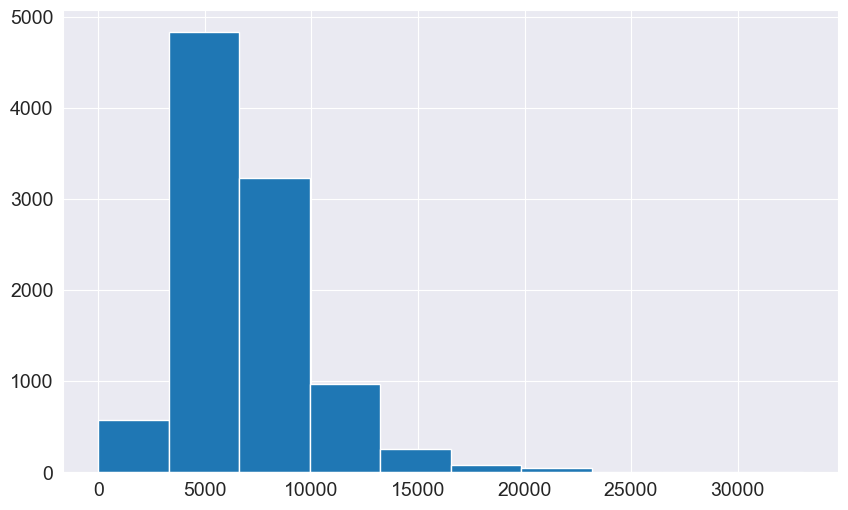

In [861]:
plt.hist(merged_df.Sales.sample(10000));

## Visualization

In [881]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [906]:
from xgboost import plot_tree
import graphviz
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 30,30

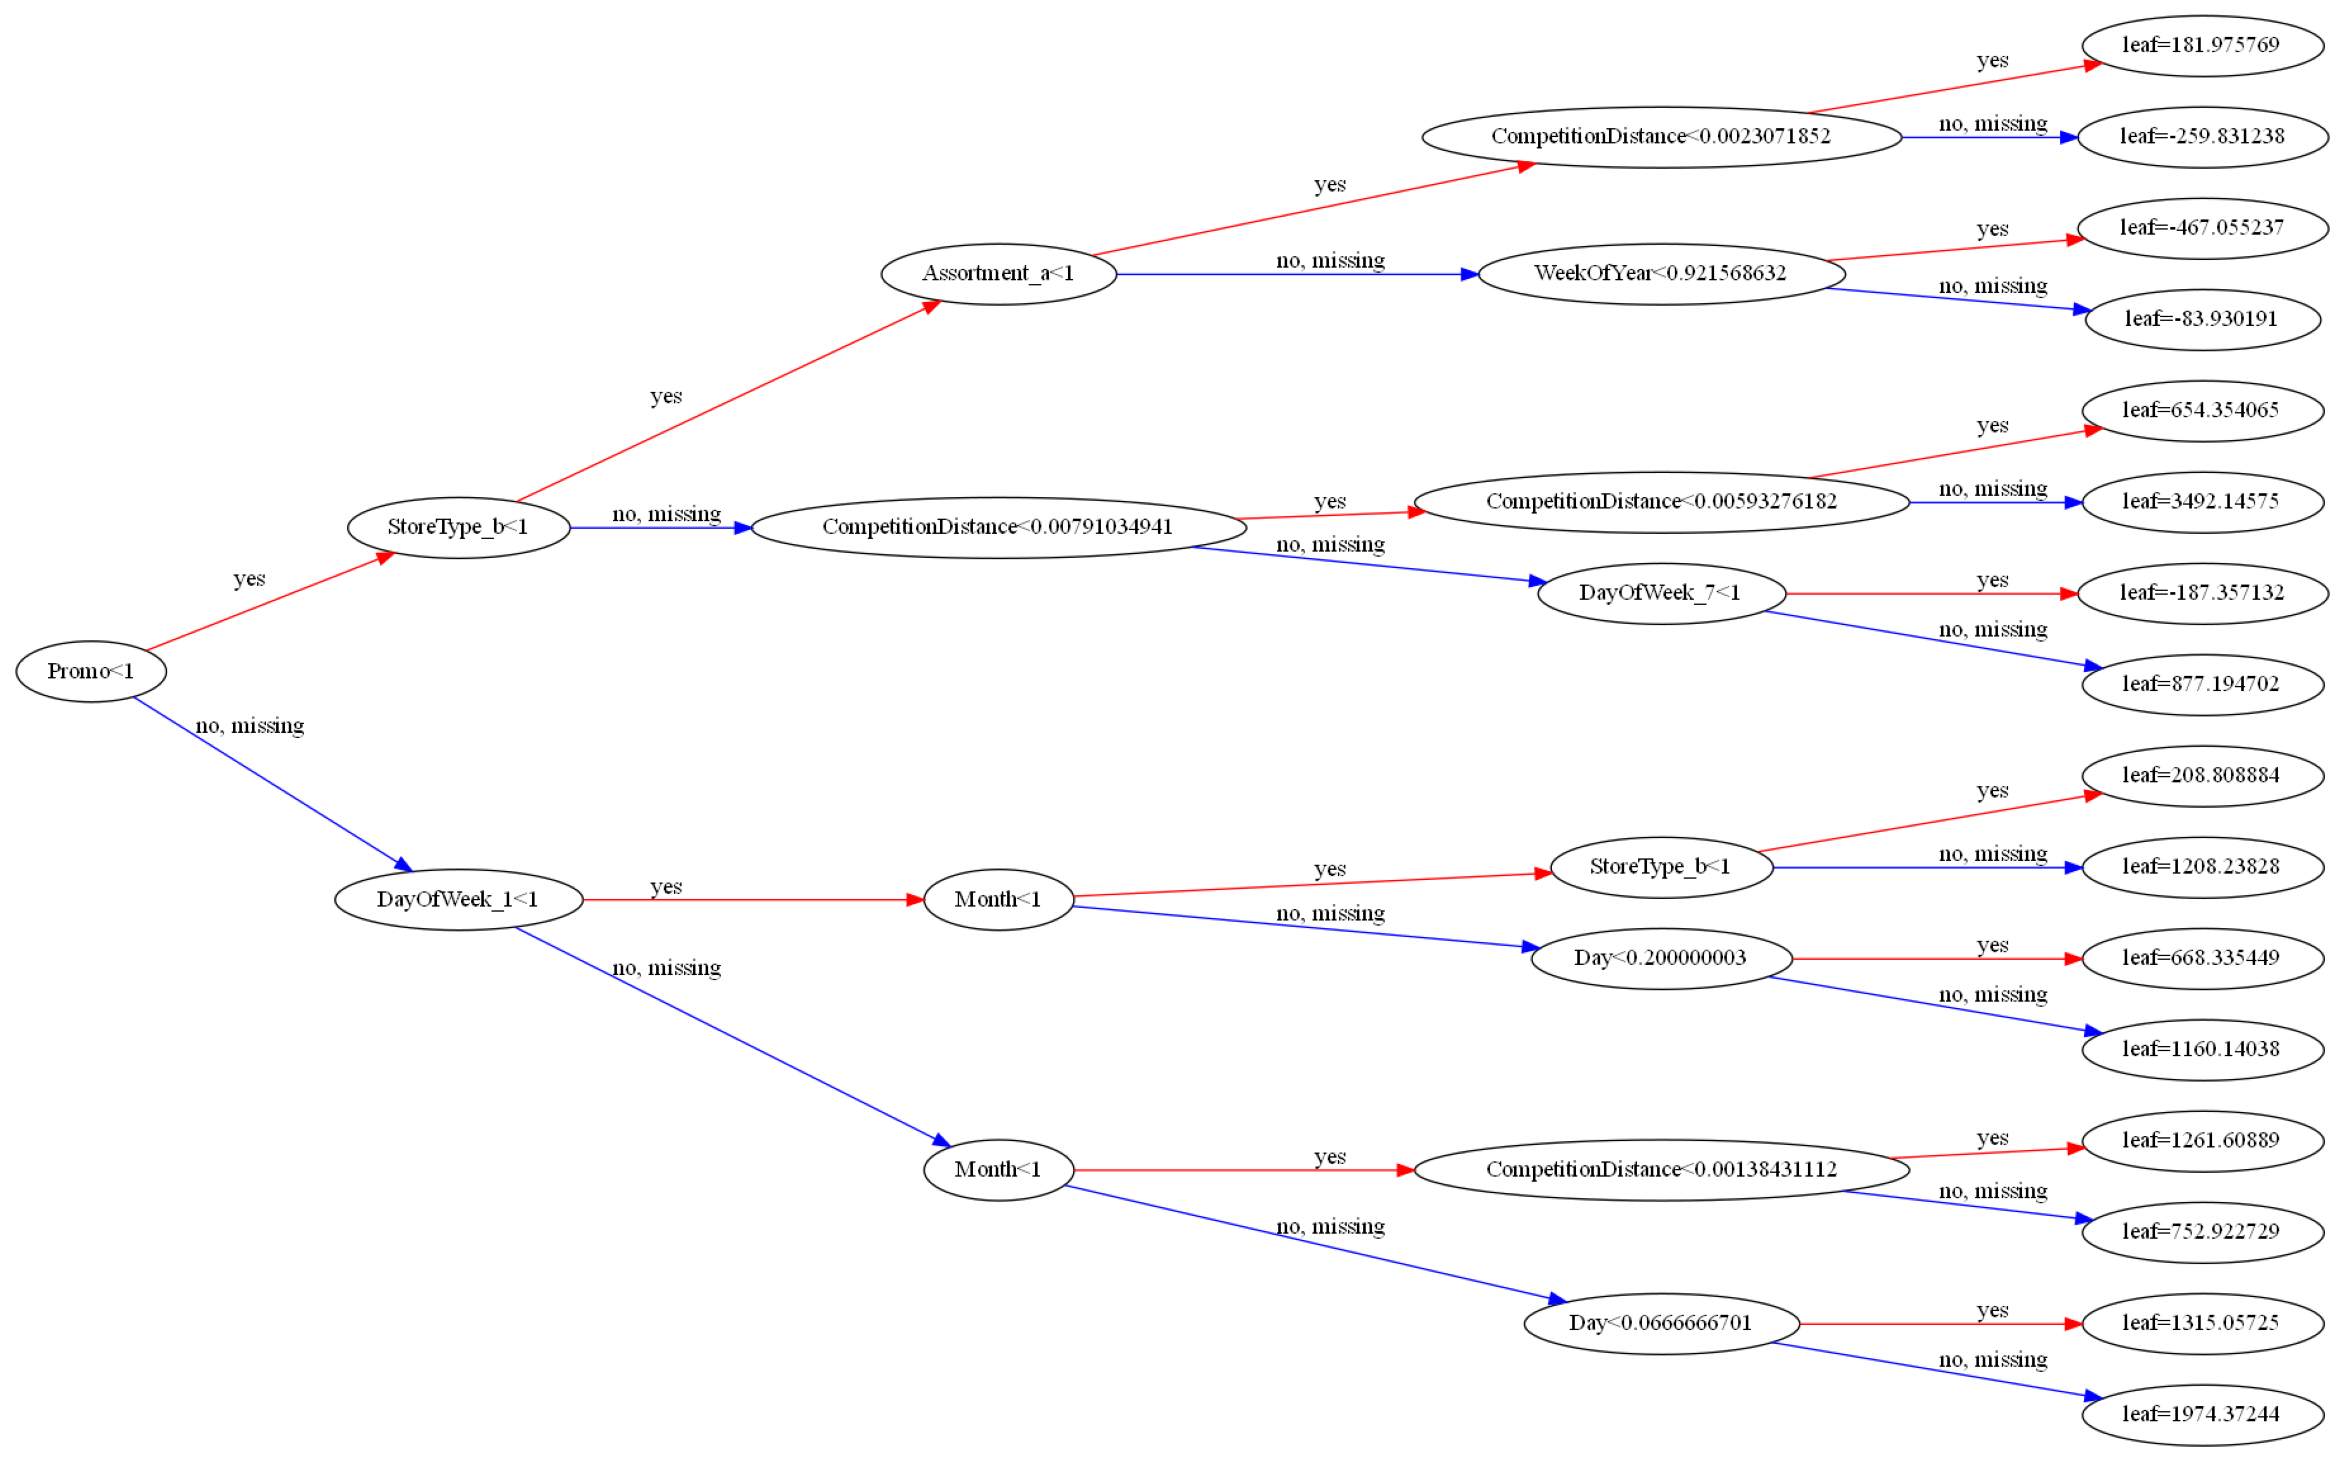

In [912]:
plot_tree(model, rankdir='LR', num_trees=0);

# rankdir='LR' means tree will be ploted left to right.
# num_trees signifies the number of the tree. Eg: num_tress=0 will plot the first tree.
# The leafs in the trees are deviations from the average 

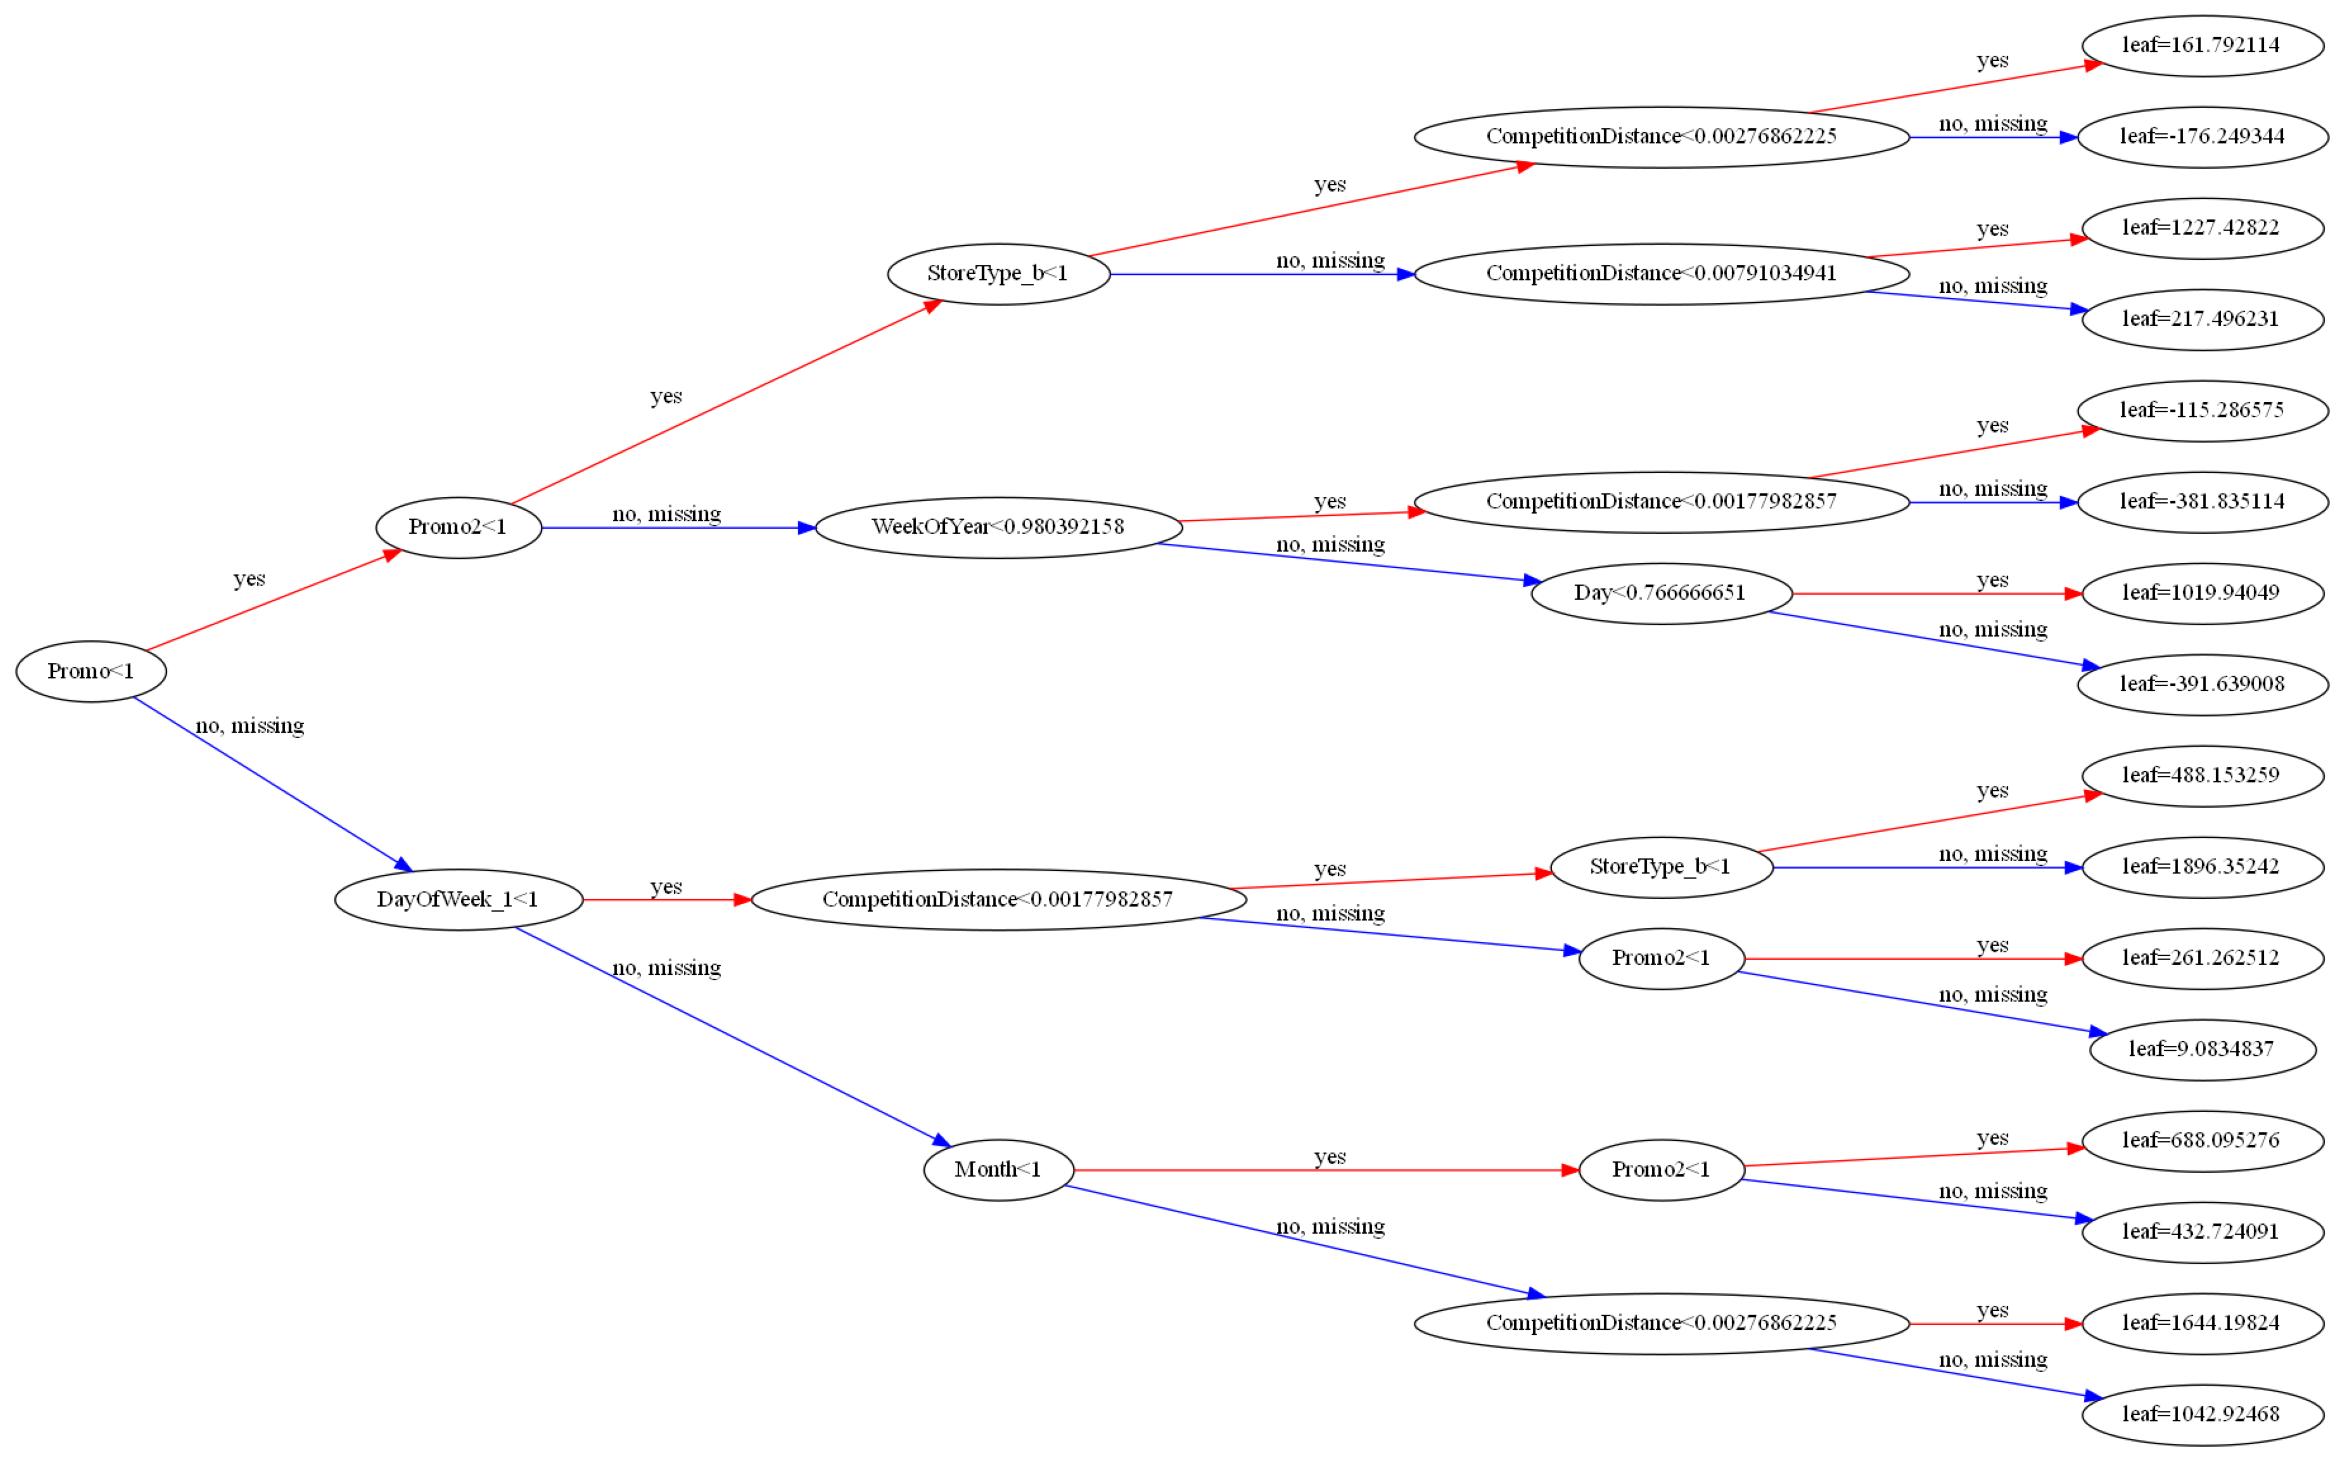

In [913]:
plot_tree(model, rankdir='LR', num_trees=1);

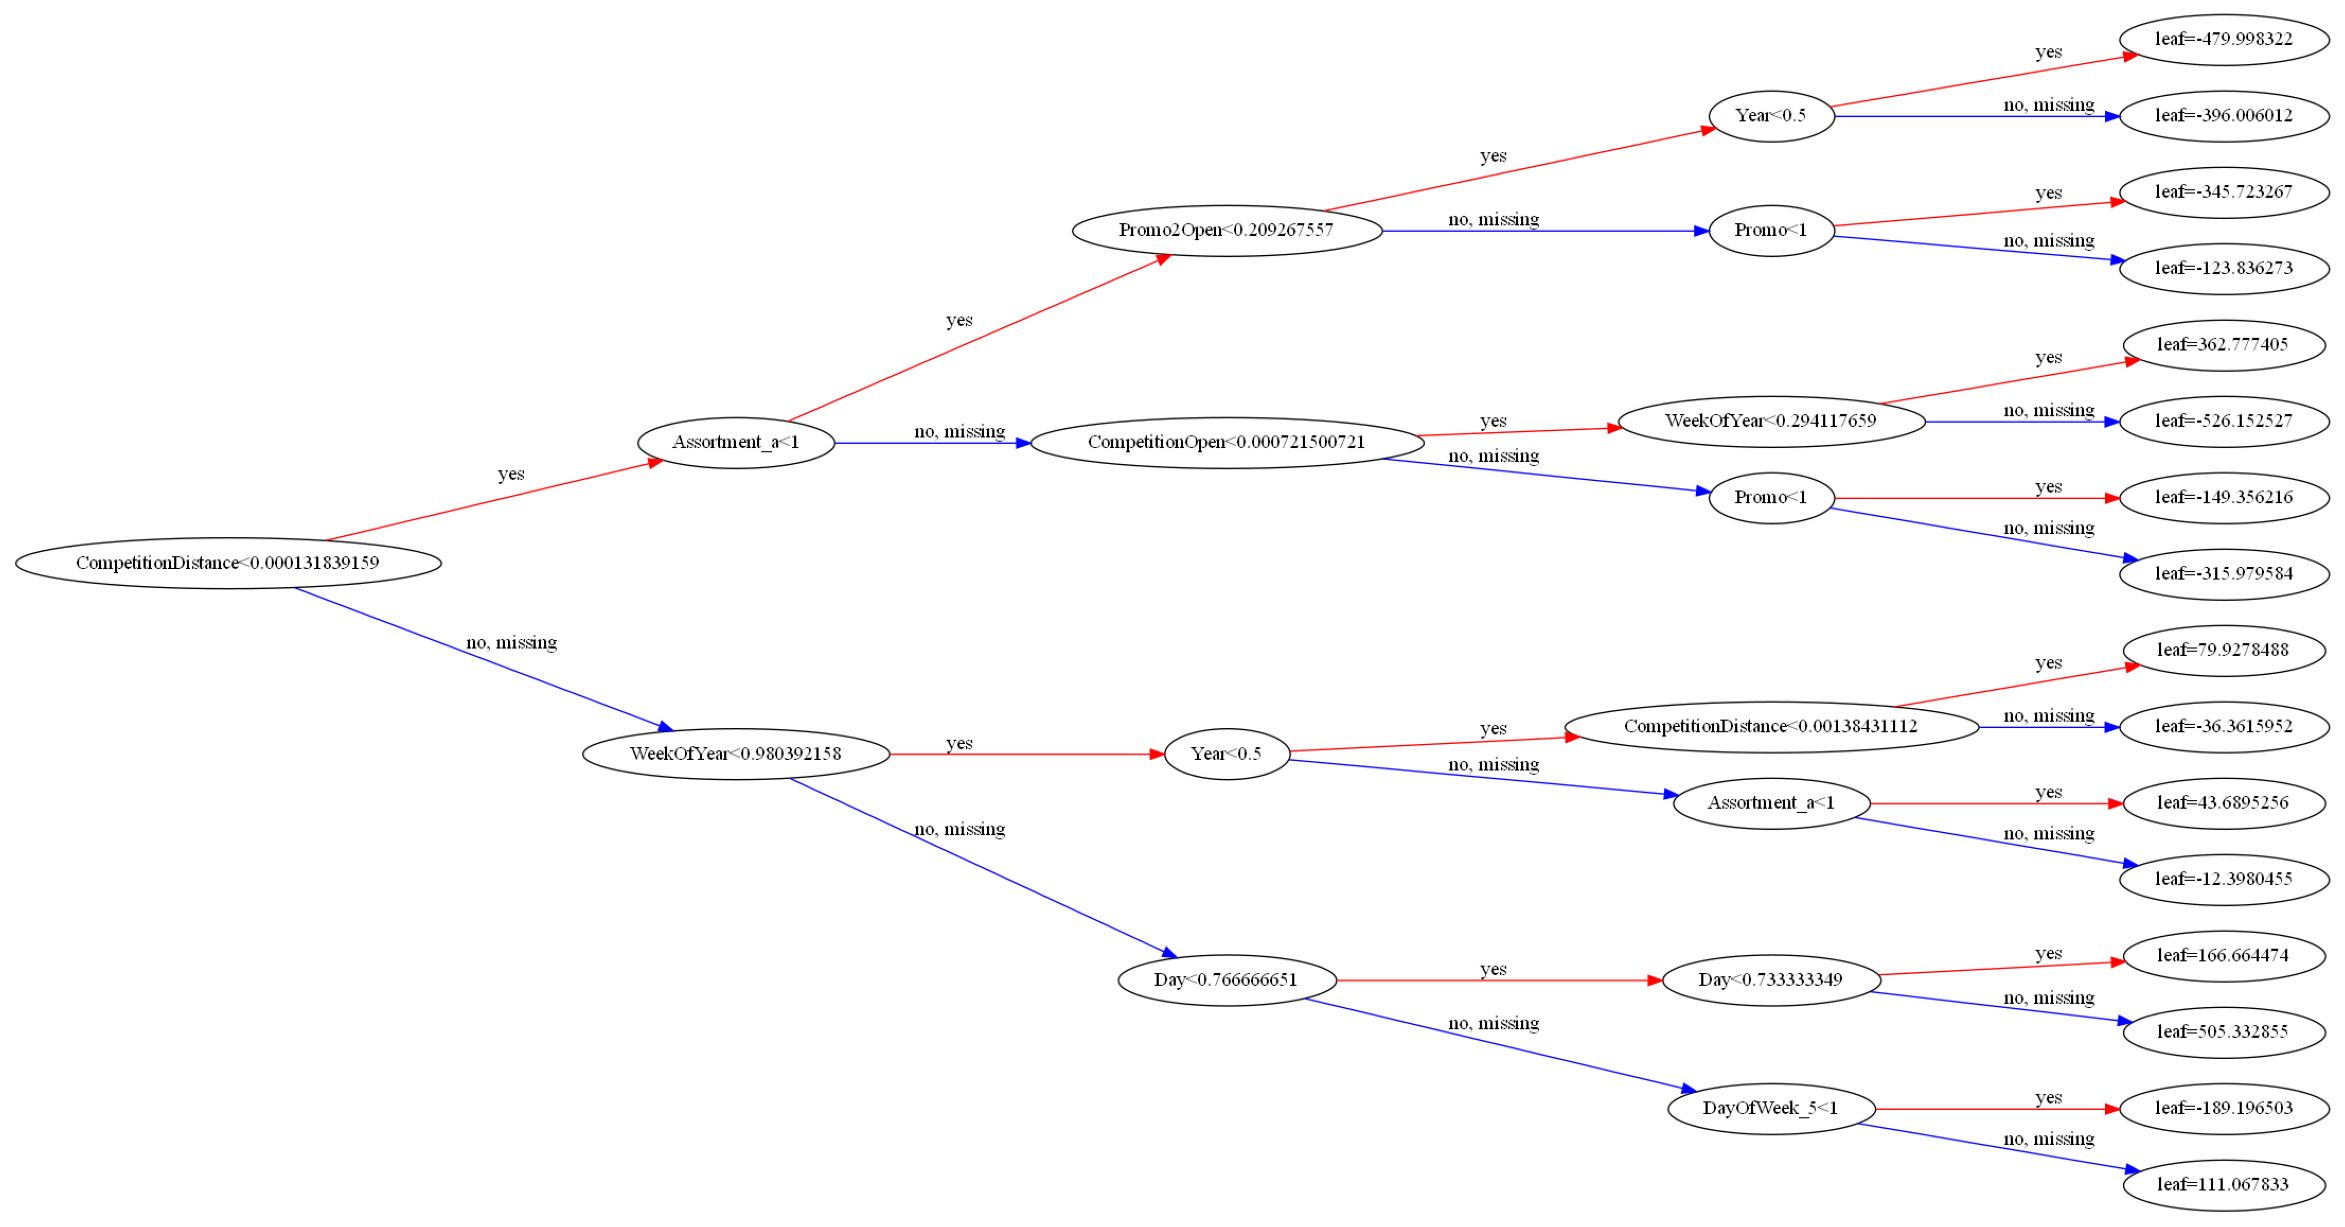

In [917]:
plot_tree(model, rankdir='LR', num_trees=19);

The trees only compute residuals, and not the actual target value

In [920]:
trees = model.get_booster().get_dump()

In [924]:
len(trees)

20

In [928]:
print(trees[0])

0:[Promo<1] yes=1,no=2,missing=2
	1:[StoreType_b<1] yes=3,no=4,missing=4
		3:[Assortment_a<1] yes=7,no=8,missing=8
			7:[CompetitionDistance<0.0023071852] yes=15,no=16,missing=16
				15:leaf=181.975769
				16:leaf=-259.831238
			8:[WeekOfYear<0.921568632] yes=17,no=18,missing=18
				17:leaf=-467.055237
				18:leaf=-83.930191
		4:[CompetitionDistance<0.00791034941] yes=9,no=10,missing=10
			9:[CompetitionDistance<0.00593276182] yes=19,no=20,missing=20
				19:leaf=654.354065
				20:leaf=3492.14575
			10:[DayOfWeek_7<1] yes=21,no=22,missing=22
				21:leaf=-187.357132
				22:leaf=877.194702
	2:[DayOfWeek_1<1] yes=5,no=6,missing=6
		5:[Month<1] yes=11,no=12,missing=12
			11:[StoreType_b<1] yes=23,no=24,missing=24
				23:leaf=208.808884
				24:leaf=1208.23828
			12:[Day<0.200000003] yes=25,no=26,missing=26
				25:leaf=668.335449
				26:leaf=1160.14038
		6:[Month<1] yes=13,no=14,missing=14
			13:[CompetitionDistance<0.00138431112] yes=27,no=28,missing=28
				27:leaf=1261.60889
				28:leaf=752

## Feature Importance

In [931]:
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False) 

importance_df.head(10)

,feature,importance
1,Promo,0.300848
12,DayOfWeek_1,0.102645
24,StoreType_b,0.086497
26,StoreType_d,0.061579
5,Promo2,0.057161
3,CompetitionDistance,0.040183
27,Assortment_a,0.038823
11,WeekOfYear,0.035640
23,StoreType_a,0.032181
9,Month,0.030912


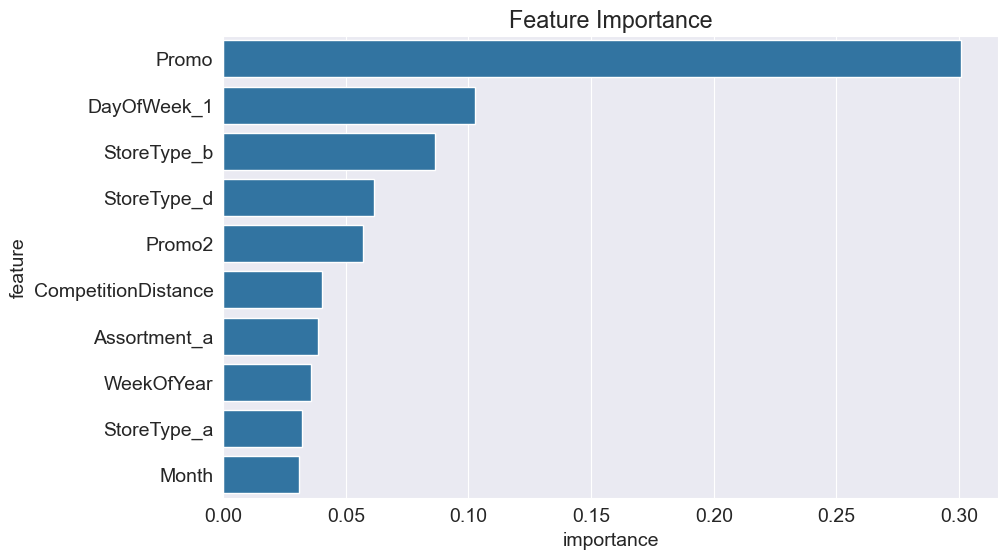

In [933]:
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

## K-Fold Cross Validation

**K-Fold Cross-Validation** is a technique used to assess the performance and generalizability of a machine learning model. It works by dividing the dataset into several subsets (called "folds") and iteratively training and testing the model on different portions of the data. Here's how it works:

---

### **Steps in K-Fold Cross-Validation**
1. **Split the Data**:
   - The dataset is divided into **K equally-sized folds**.
   - For example, if \( K = 5 \), the data is split into 5 subsets.

2. **Iterative Training and Testing**:
   - For each iteration, one fold is used as the **validation set** (test set), and the remaining \( K-1 \) folds are used as the **training set**.
   - This process is repeated \( K \) times, ensuring each fold is used as a validation set exactly once.

3. **Compute Metrics**:
   - After each iteration, evaluation metrics (like accuracy, RMSE, etc.) are computed for the validation set.
   - These metrics are averaged across all \( K \) folds to provide an overall performance estimate.

---

### **Advantages**
- **Reduces Overfitting**: Since the model is trained and tested on multiple splits of the data, it provides a more reliable estimate of performance.
- **Efficient Use of Data**: Unlike a simple train-test split, all data points are used for both training and testing at some point.

---

### **Common Variants**
- **Stratified K-Fold**:
  - Ensures that the proportion of classes in classification problems is maintained in each fold.
- **Leave-One-Out Cross-Validation (LOOCV)**:
  - A special case where \( K \) equals the number of samples. Each sample is used as a validation set once.
- **Repeated K-Fold**:
  - The process of K-Fold is repeated multiple times to further improve reliability.

---

### **Python Implementation**
Using `scikit-learn`:

```python
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

# Example Dataset
X, y = make_regression(n_samples=100, n_features=10, noise=0.1)

# Model
model = RandomForestRegressor()

# K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')

# Results
print("MSE scores for each fold:", -scores)
print("Average MSE:", -scores.mean())
```

Replace `RandomForestRegressor` with your desired model.

In [938]:
from sklearn.model_selection import KFold

In [949]:
def train_and_evaluate(X_train, train_targets, X_val, val_targets, **params):
    model = XGBRegressor(random_state=42, n_jobs=-1, **params)
    model.fit(X_train, train_targets)
    train_rmse = rmse(model.predict(X_train), train_targets)
    val_rmse = rmse(model.predict(X_val), val_targets)
    return model, train_rmse, val_rmse

Now, we can use the KFold utility to create the different training/validation splits and train a separate model for each fold.

In [952]:
kfold = KFold(n_splits=5)    # Can also use shuffle = True

In [958]:
models = []

for train_idxs, val_idxs in kfold.split(X):
    X_train, train_targets = X.iloc[train_idxs], targets.iloc[train_idxs]
    X_val, val_targets = X.iloc[val_idxs], targets.iloc[val_idxs]
    model, train_rmse, val_rmse = train_and_evaluate(X_train, 
                                                     train_targets, 
                                                     X_val, 
                                                     val_targets,
                                                     max_depth=4,
                                                     n_estimators=20)
    models.append(model)
    print(f'Train RMSE: {train_rmse}, Validation RMSE: {val_rmse}')

# train_idxs, val_idxs are indexes of rows for the training and validation sets for each split

C:\Users\VIVEK\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\VIVEK\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Train RMSE: 2391.4844108755224, Validation RMSE: 2452.493311050122


C:\Users\VIVEK\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\VIVEK\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Train RMSE: 2411.1429644107884, Validation RMSE: 2459.7302552175574


C:\Users\VIVEK\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\VIVEK\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Train RMSE: 2417.1283480051334, Validation RMSE: 2395.9854510168902


C:\Users\VIVEK\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\VIVEK\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Train RMSE: 2369.1940748324337, Validation RMSE: 2475.0098525280155
Train RMSE: 2366.3675904930874, Validation RMSE: 2433.0968345140213


C:\Users\VIVEK\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\VIVEK\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Let's define a function to average predictions from the 5 different models

In [963]:
def predict_avg(models, inputs):
    return np.mean([model.predict(inputs) for model in models], axis=0)

In [967]:
preds

array([ 8084.615 ,  7515.6963,  8841.63  , ...,  7761.8774,  8491.411 ,
       11003.013 ], dtype=float32)

## Hyperparameter Tuning and Regularization

In [976]:
def test_params_kfold(n_splits, **params):
    train_rmses, val_rmses, models = [], [], []
    kfold = KFold(n_splis)
    for train_idxs, val_idxs in kfold.split(X):
        X_train, train_targets = X.iloc[train_idxs], targets.iloc[train_idxs]
        X_val, val_targets = X.iloc[val_idxs], targets.iloc[val_idxs]
        model, train_rmse, val_rmse = train_and_evaluate(X_train, 
                                                         train_targets, 
                                                         X_val, 
                                                         val_targets,
                                                         **params)
        models.append(model)
        train_rmses.append(train_rmse)
        val_rmses.append(val_rmse)
    print(f'Train RMSE: {np.mean(train_rmse)}, Validation RMSE: {np.mean(val_rmse)}')
    return models

In [978]:
from sklearn.model_selection import train_test_split

In [980]:
X_train, X_val, train_targets, val_targets = train_test_split(X, targets, test_size=0.1)

In [984]:
def test_params(**params):
    model = XGBRegressor(random_state=42, n_jobs=-1, **params)
    model.fit(X_train, train_targets)
    train_rmse = rmse(model.predict(X_train), train_targets)
    val_rmse = rmse(model.predict(X_val), val_targets)
    print(f'Train RMSE: {train_rmse}, Validation RMSE: {val_rmse}')

### n_estimators

The number of trees to be created. More trees = greater capacity of the model.

In [988]:
test_params(n_estimators=10)

Train RMSE: 2382.964872425665, Validation RMSE: 2395.766603117876


C:\Users\VIVEK\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\VIVEK\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [990]:
test_params(n_estimators=30)

Train RMSE: 1858.7158020006932, Validation RMSE: 1868.4441418426338


C:\Users\VIVEK\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\VIVEK\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [992]:
test_params(n_estimators=100)

Train RMSE: 1181.829947482462, Validation RMSE: 1191.193499837539


C:\Users\VIVEK\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\VIVEK\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [996]:
test_params(n_estimators=240)

Train RMSE: 912.9269422950028, Validation RMSE: 930.3367890986551


C:\Users\VIVEK\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\VIVEK\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### max_depth

As we increase the max_depth of each tree, the capacity of the tree increases and it can capture more information about the training set.

In [1004]:
test_params(max_depth=2, n_estimators=10)

Train RMSE: 2687.6244570539116, Validation RMSE: 2697.0001499407244


C:\Users\VIVEK\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\VIVEK\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [1006]:
test_params(max_depth=5, n_estimators=10)

Train RMSE: 2443.7530422573154, Validation RMSE: 2456.786485644657


C:\Users\VIVEK\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\VIVEK\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [1008]:
test_params(max_depth=10, n_estimators=10)

Train RMSE: 1861.5466134796943, Validation RMSE: 1896.3778349637125


C:\Users\VIVEK\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\VIVEK\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### learning_rate

The scaling factor to be applied to the prediction of each tree. A very high learning rate (close to 1) will lead to overfitting, and a low learning rate (close to 0) will lead to underfitting

In [1012]:
test_params(learning_rate=0.01, n_estimators=10)

Train RMSE: 3018.195215063851, Validation RMSE: 3027.6865704987226


C:\Users\VIVEK\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\VIVEK\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [1014]:
test_params(learning_rate=0.1, n_estimators=10)

Train RMSE: 2626.3644398693464, Validation RMSE: 2637.9725833779066


C:\Users\VIVEK\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\VIVEK\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [1016]:
test_params(learning_rate=0.3, n_estimators=10)

Train RMSE: 2382.964872425665, Validation RMSE: 2395.766603117876


C:\Users\VIVEK\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\VIVEK\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [1018]:
test_params(learning_rate=0.9, n_estimators=10)

Train RMSE: 1860.7659034415888, Validation RMSE: 1873.6077193272092


C:\Users\VIVEK\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\VIVEK\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [1020]:
test_params(learning_rate=0.99, n_estimators=10)

Train RMSE: 1891.0564767344233, Validation RMSE: 1894.9242000438421


C:\Users\VIVEK\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\VIVEK\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### booster

Instead of using Deciso+ion Trees, XGBoost can also train a linear model for each iteration. This can be configured using `booster`.

In [1024]:
test_params(booster='gblinear')

Train RMSE: 2726.329960149378, Validation RMSE: 2735.9260892196567


C:\Users\VIVEK\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\VIVEK\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Clearly, a linear model is suited for our dataset.

## Putting it Together and Making Predictions

Training the final model on the entire training set with custom hyperparameters.

In [1047]:
model = XGBRegressor(n_jobs=-1, random_state=42, n_estimators=1000,
                     learning_rate=0.2, max_depth=10, subsample=0.9,
                     colsample_bytree=0.7)

# subsample: Controls the fraction of training samples (rows) used for building each tree to prevent overfitting (e.g., 0.9 means 90% of samples are used).  
# colsample_bytree: Specifies the fraction of features (columns) randomly sampled for building each tree (e.g., 0.7 means 70% of features are used).
# Basically, each decision tree will use 70% of the columns.

In [1049]:
%%time
model.fit(X, targets)

CPU times: total: 8min 43s
Wall time: 58.1 s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

Now that the model has been trained, we can make predictions on the test set.

In [1063]:
train_preds = model.predict(X_train)
rmse(train_preds, train_targets)

C:\Users\VIVEK\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


391.1178420210946

In [1065]:
X_test

,Store,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpen,Promo2,Promo2Open,IsPromo2Month,Day,Month,Year,WeekOfYear,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c
0,0.000000,1.0,0.0,0.008240,0.060606,0.0,0.000000,0.0,0.533333,0.727273,1.0,0.725490,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.001795,1.0,0.0,0.093013,0.075758,1.0,0.484305,0.0,0.533333,0.727273,1.0,0.725490,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.005386,1.0,0.0,0.158075,0.020924,0.0,0.000000,0.0,0.533333,0.727273,1.0,0.725490,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.006284,1.0,0.0,0.049440,0.007937,0.0,0.000000,0.0,0.533333,0.727273,1.0,0.725490,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.007181,1.0,0.0,0.013250,0.130592,0.0,0.000000,0.0,0.533333,0.727273,1.0,0.725490,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41083,0.996409,0.0,0.0,0.012393,0.010101,1.0,0.008969,0.0,0.000000,0.636364,1.0,0.588235,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
41084,0.997307,0.0,0.0,0.012261,0.080808,0.0,0.000000,0.0,0.000000,0.636364,1.0,0.588235,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
41085,0.998205,0.0,0.0,0.060910,0.000000,0.0,0.000000,0.0,0.000000,0.636364,1.0,0.588235,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
41086,0.999102,0.0,0.0,0.005603,0.000000,0.0,0.000000,0.0,0.000000,0.636364,1.0,0.588235,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [1055]:
test_preds = model.predict(X_test)

In [1056]:
test_preds

array([ 4237.239 ,  8101.6   ,  9607.315 , ...,  6446.96  , 23767.295 ,
        6784.4253], dtype=float32)

We'll add the predictions into the `submission_df`.

In [1069]:
submission_df

,Id,Sales
0,1,4237.238770
1,2,8101.600098
2,3,9607.315430
3,4,7109.257812
4,5,7226.040039
...,...,...
41083,41084,2347.026855
41084,41085,7709.408203
41085,41086,6446.959961
41086,41087,23767.294922


In [1067]:
submission_df['Sales'] = test_preds

However, if the store is not open, then the sales must be 0. Thus, whenever the value of `Open` in the test set is 0, we can set the sales to 0. Also, there are some missing values for `Open` in the test set. We'll replace them with 1 (open).

In [1072]:
test_df.Open.isna().sum()

11

In [1074]:
submission_df['Sales'] = submission_df['Sales'] * test_df.Open.fillna(1.)

In [1076]:
submission_df

,Id,Sales
0,1,4237.238770
1,2,8101.600098
2,3,9607.315430
3,4,7109.257812
4,5,7226.040039
...,...,...
41083,41084,2347.026855
41084,41085,7709.408203
41085,41086,6446.959961
41086,41087,23767.294922


We can now save the submission as a `CSV` file

In [1079]:
submission_df.to_csv('submission.csv', index=None)

In [1081]:
from IPython.display import FileLink

In [1083]:
FileLink('submission.csv')

C:\Users\VIVEK\submission.csv